In [258]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from kneed import KneeLocator as kl
import scanpy as sc

sc.settings.verbosity = 2
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='lightyellow')

path = '/Users/devpatelio/Downloads/Coding/Computational_Biology/SingleCell-RNAseq/cancer-cell-master/filtered_feature_bc_matrix'
results_file = path + 'hodgkins.h5ad'
adata = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)

... reading from cache file cache/Users-devpatelio-Downloads-Coding-Computational_Biology-SingleCell-RNAseq-cancer-cell-master-filtered_feature_bc_matrix-matrix.h5ad


scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 louvain==0.7.0


normalizing counts per cell
    finished (0:00:00)


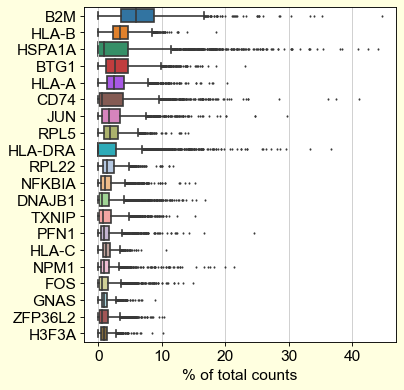

AnnData object with n_obs × n_vars = 3049 × 1253
    var: 'gene_ids', 'feature_types'


In [259]:
sc.pl.highest_expr_genes(adata, n_top=20)
print(adata)

Your dataset consists of cells with the following %s of mitochondrial genes:
0.0%


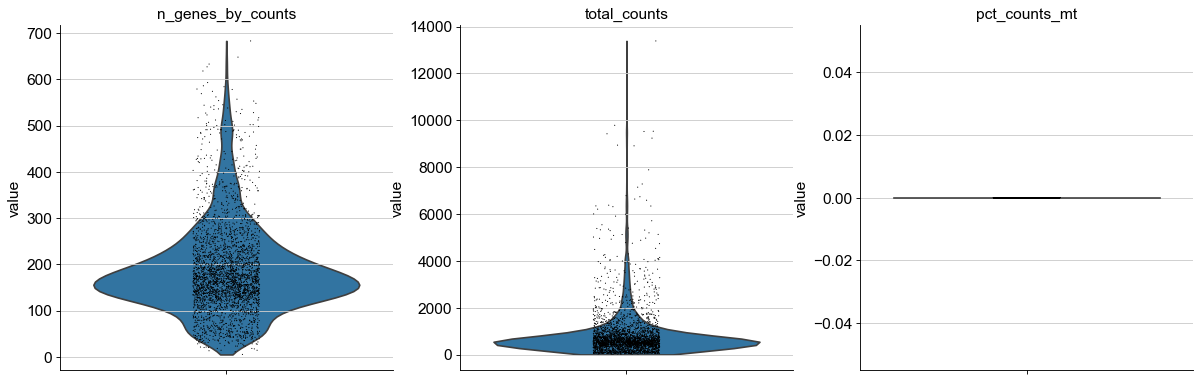

/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

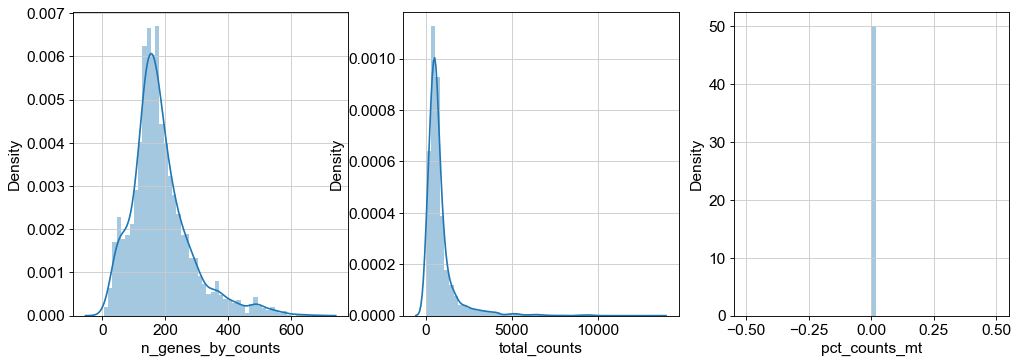

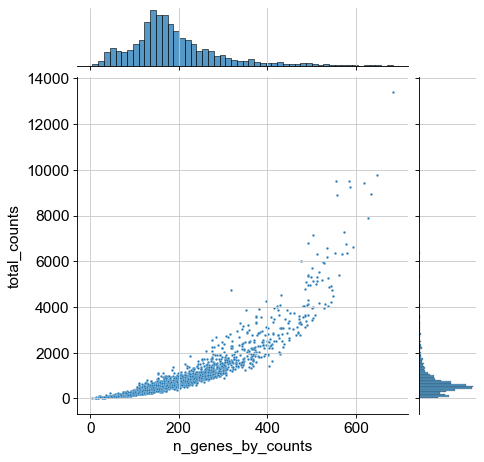

In [187]:
#Looking for genes originating from mitochondrial genes
def percent_mitochondrial(data):
    data.var['mt'] = data.var_names.str.startswith('MT-')
    all_keys = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
    sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=False, log1p=False, inplace=True)
    diff_percents = set(data.obs.pct_counts_mt.values)
    print(f"Your dataset consists of cells with the following %s of mitochondrial genes:") 
    for i in list(diff_percents):
        print(str(i)+'%')
    
    return data.obs.pct_counts_mt.value_counts, data.obs.pct_counts_mt, set(data.obs.pct_counts_mt.values)
    
all_counts_length, all_counts, diff_percents = percent_mitochondrial(adata)

#Evaluating quality of dataset based on standard measures -> gene counts, total_counts, etc.
def plot_quality(data, objs, k=3):
    sc.pl.violin(data, [i for i in objs], multi_panel=True)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.distplot(data.obs[objs[0]], ax=axes[0])
    sns.distplot(data.obs[objs[1]], ax=axes[1])
    sns.distplot(data.obs[objs[2]], ax=axes[2])

    sns.jointplot(
    x=objs[0],
    y=objs[1],
    data = data.obs,
    kind="scatter",
    s=5
    )

plot_quality(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'])

filtered out 2025 cells that have less than 200 genes expressed
filtered out 164 genes that are detected in less than 3 cells


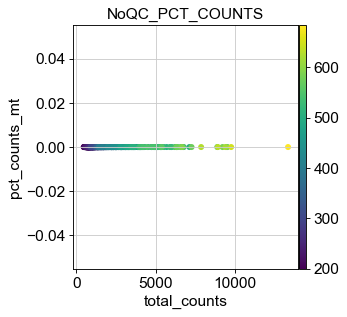

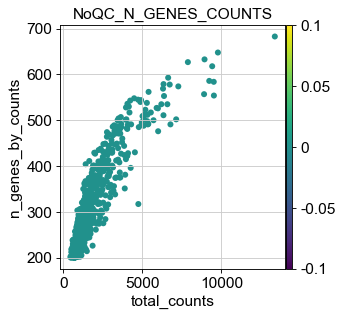

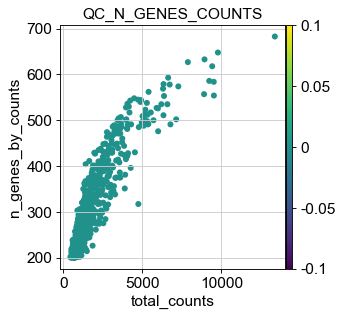

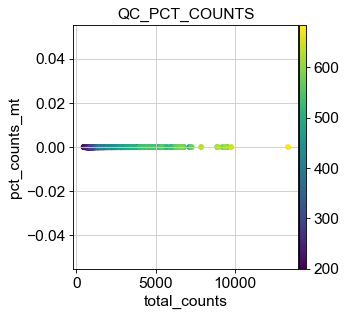

In [88]:

def calc_filter_nums(data):
    sc.pp.filter_cells(data, min_genes=200)
    sc.pp.filter_genes(data, min_cells=3)

    sc.pl.scatter(data, x='total_counts', y='pct_counts_mt', color='n_genes_by_counts', title='NoQC_PCT_COUNTS')
    sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', title='NoQC_N_GENES_COUNTS')

    filter_threshold_gene_counts = int(input('Please enter a gene_count filter slice value:'))
    filter_threshold_pct_counts = int(input('Please enter a pct_count_mt filter slice value:'))

    qc_gc = data[data.obs.n_genes_by_counts < filter_threshold_gene_counts, :]
    sc.pl.scatter(qc_gc, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', title='QC_N_GENES_COUNTS')    
    try:
        qc_gc = qc_gc[qc_gc.obs.pct_counts_mt < filter_threshold_pct_counts, :]
        sc.pl.scatter(qc_gc, x='total_counts', y='pct_counts_mt', color='n_genes_by_counts', title='QC_PCT_COUNTS')
    except ZeroDivisionError:
        print('Your total percent of mitochondrial genes are 0%')

    return qc_gc

QC_data = adata.copy()
QC_data = calc_filter_nums(QC_data)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


*Note, hyperparams should be [min_mean, max_mean, min_disp]


    finished (0:00:00)


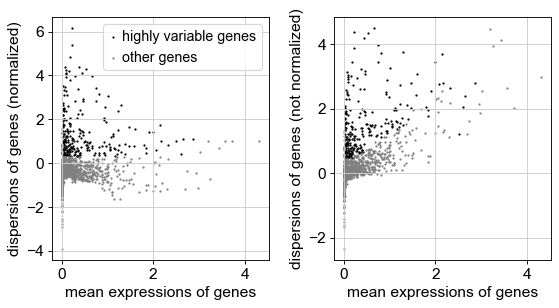

AnnData object with n_obs × n_vars = 1024 × 1089
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [124]:
def hvgs (data, target, hyperparams, plot=True):
    print('*Note, hyperparams should be [min_mean, max_mean, min_disp]')
    
    def norm_log_data(data, target):
        sc.pp.normalize_total(data, target_sum=target)
        sc.pp.log1p(data)

    norm_log_data(data, target)
    hvgs = data
    sc.pp.highly_variable_genes(hvgs, min_mean=hyperparams[0], max_mean=hyperparams[1], min_disp=hyperparams[2])

    if plot:
        sc.pl.highly_variable_genes(hvgs)
    else:
        pass

    return hvgs


norm_data = QC_data.copy()
HVG = hvgs(norm_data, 1e3, [0.0125, 3, 0.3])

In [131]:
#Remove any effect of the pct_counts after being filtered out and total_counts on data topology (we're looking at highly variable genes so we want to keep the data clean)
HVGfiltered = HVG[:, HVG.var.highly_variable]
sc.pp.regress_out(HVGfiltered, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(HVGfiltered, max_value=10)

print(len(HVGfiltered))  #HVG Counts
print(len(adata))  #All Genes Count
print(f"The total % of all data that is of interest based on its high variability is {round(len(HVG_filtered)/len(adata) * 100, 3)}%") #Calculate total HVG interest

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:00)


1024
3049
The total % of all data that is of interest based on its high variability is 33.585%


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


Total High Variable Genes: 240


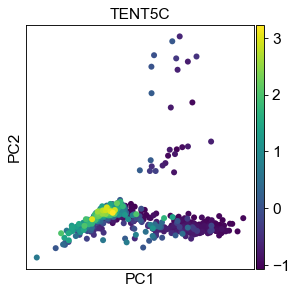

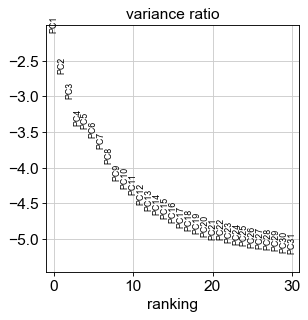

/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


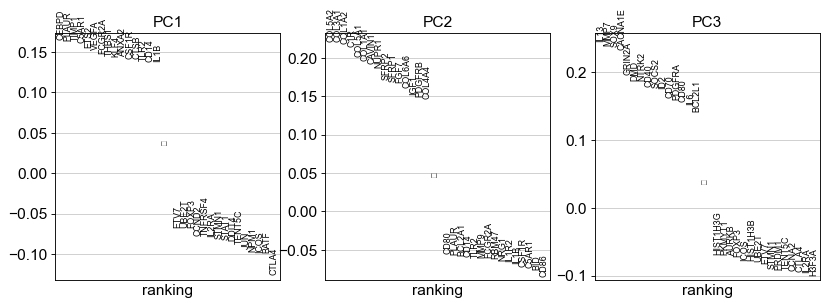

AnnData object with n_obs × n_vars = 1024 × 240
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [149]:
import random

high_variable_genes_names = HVGfiltered.var_names
print(f"Total High Variable Genes: {len(high_variable_genes_names)}")

sc.tl.pca(HVGfiltered, svd_solver='arpack')
sc.pl.pca(HVGfiltered, color=random.choice(high_variable_genes_names))
sc.pl.pca_variance_ratio(HVGfiltered, log=True)
sc.pl.pca_loadings(HVGfiltered)
HVGfiltered.write(results_file)
print(HVGfiltered)


In [183]:
def PCA_Elbow_fit(data): #We look each pricniple component based on its proportion of variance, and only include the pcs once a drop in variance is found 
    model = sklearn.decomposition.PCA()
    model.fit(data) #calculate PCA on data inputted
    explained_variance = model.explained_variance_ratio_ #look at the variance ratio or loadings
    pcs = list(range(1, explained_variance.shape[0]+1)) #renumber all pcs from 1 to all variance_shapes (index 0 provides number)
    klm = kl(pcs, explained_variance, S=1.0, curve='convex', direction='decreasing') #knee locator finds the drop in variance with a convex curve (can be concave too), direction is based on PC order
    klm.plot_knee()
    pcs_used = klm.knee #find the pcs up until the start of the knee (attribute of klm object)
    pc_list = list(range(1, pcs_used+1))  #lists all numbers of PCs used
    new_data = sklearn.decomposition.PCA(n_components=pcs_used, svd_solver='arpack').fit_transform(data) #recalculate PCA on data with only the total PCA components found

   
    return pcs_used, new_data, pcs, explained_variance, pc_list #return number of pcs, PC data embedding with new PCS, number of all initial PCs, variance of previous PCs, list of all new PCs

label = "HVGfiltered"
new_frame = pd.DataFrame(HVGfiltered.X, index=HVGfiltered.obs_names, columns=HVGfiltered.var_names) #only want the variable names, objects, and expression values
pandas_data = new_frame.values #assign values to a new frame


17
                        PC_1      PC_2      PC_3      PC_4      PC_5  \
AAACCCAGTATTTCCT-1 -4.737694 -1.808935 -4.260551 -0.712057  3.831951   
AAACGAAGTGGGTATG-1  3.864460 -4.350157 -5.045168  0.548488 -4.118454   

                        PC_6      PC_7      PC_8      PC_9     PC_10  \
AAACCCAGTATTTCCT-1 -0.765918  0.449926  0.899391 -1.656464  0.181562   
AAACGAAGTGGGTATG-1 -1.614742 -0.120299  0.752264 -1.869767 -0.510367   

                       PC_11     PC_12     PC_13     PC_14     PC_15  \
AAACCCAGTATTTCCT-1  1.595945 -0.675169 -3.970789 -0.190194  0.590685   
AAACGAAGTGGGTATG-1 -1.305388  1.975733  0.207802 -0.257919  0.655795   

                       PC_16     PC_17  
AAACCCAGTATTTCCT-1  1.147153  1.186836  
AAACGAAGTGGGTATG-1 -1.147465  0.712766  
(1024, 17)


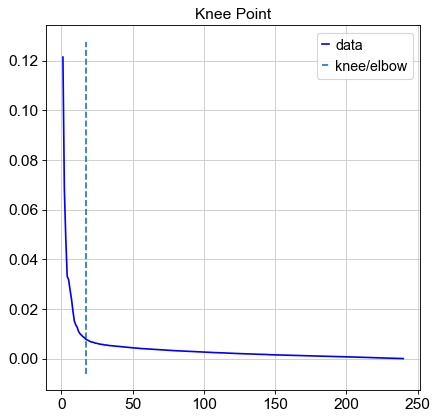

In [186]:
dim, new_pca_data, pc_ax, pc_ay, col_labels = PCA_Elbow_fit(pandas_data) #calculate PCA Elbow fit on formatted data
print(dim) #17 PCs were used out of the 31

output_path = path + '_PCA_' + label + str(dim) + '.csv' #output these values to a csv for reference
PC_frame = pd.DataFrame(new_pca_data, index=new_frame.index.values.tolist(), columns=['PC_' + str(i) for i in col_labels]) #create dataframe with and columns to create dataframe with PC variance ratio with respect to each gene (PC_1 will always have highest variance)
print(PC_frame.head(2))
print(PC_frame.shape)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:01)


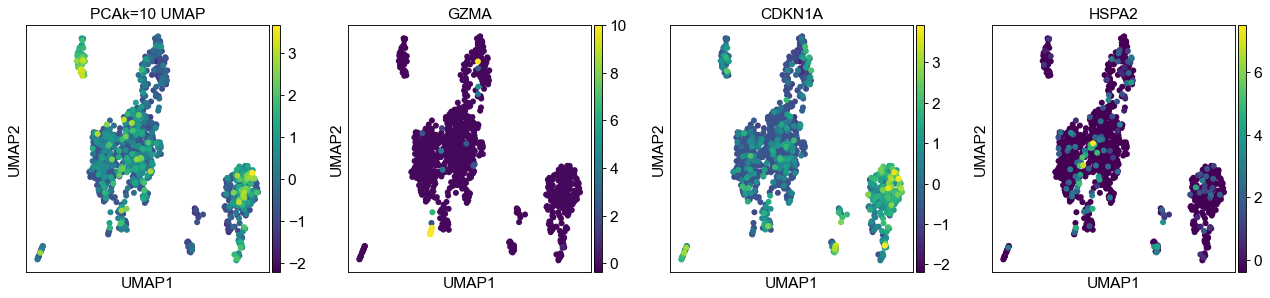

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:06)


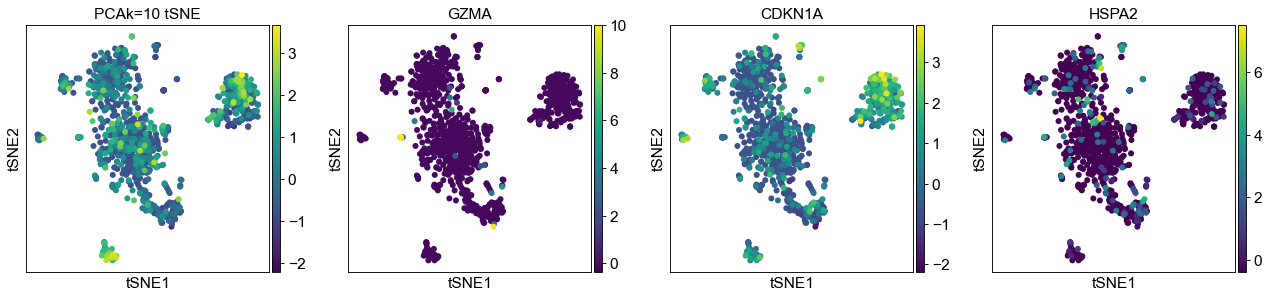

In [214]:
#Computing neighbourhood graphs

pcaHVG10 = HVGfiltered.copy()

def tsne_umap_plot(k, var_k, color_n=3, colors=None):
    if colors == None:
        colors = random.sample(list(high_variable_genes_names), color_n)
    sc.pp.neighbors(var_k, n_neighbors=k)   #calculate k-neighbours
    
    #UMAP
    sc.tl.umap(var_k)
    sc.pl.umap(var_k, color=colors, title=f'PCAk={k} UMAP')

    #TSNE
    sc.tl.tsne(var_k)
    sc.pl.tsne(var_k, color=colors, title=f'PCAk={k} tSNE')
    

tsne_umap_plot(10, pcaHVG10, 4)





running Leiden clustering
    finished (0:00:00)


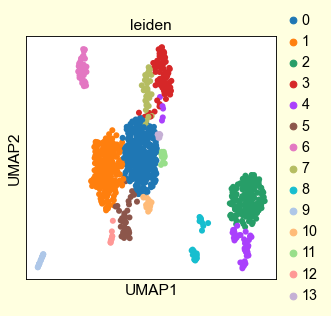

In [260]:
#Generating clusters in data
# fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sc.tl.leiden(pcaHVG10)
sc.pl.umap(pcaHVG10, color=['leiden']) #leiden directly uses the k-neighbours plot based on our different PCA embeddings, so the result will look different
pcaHVG10.write(results_file)


ranking genes
/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished (0:00:00)


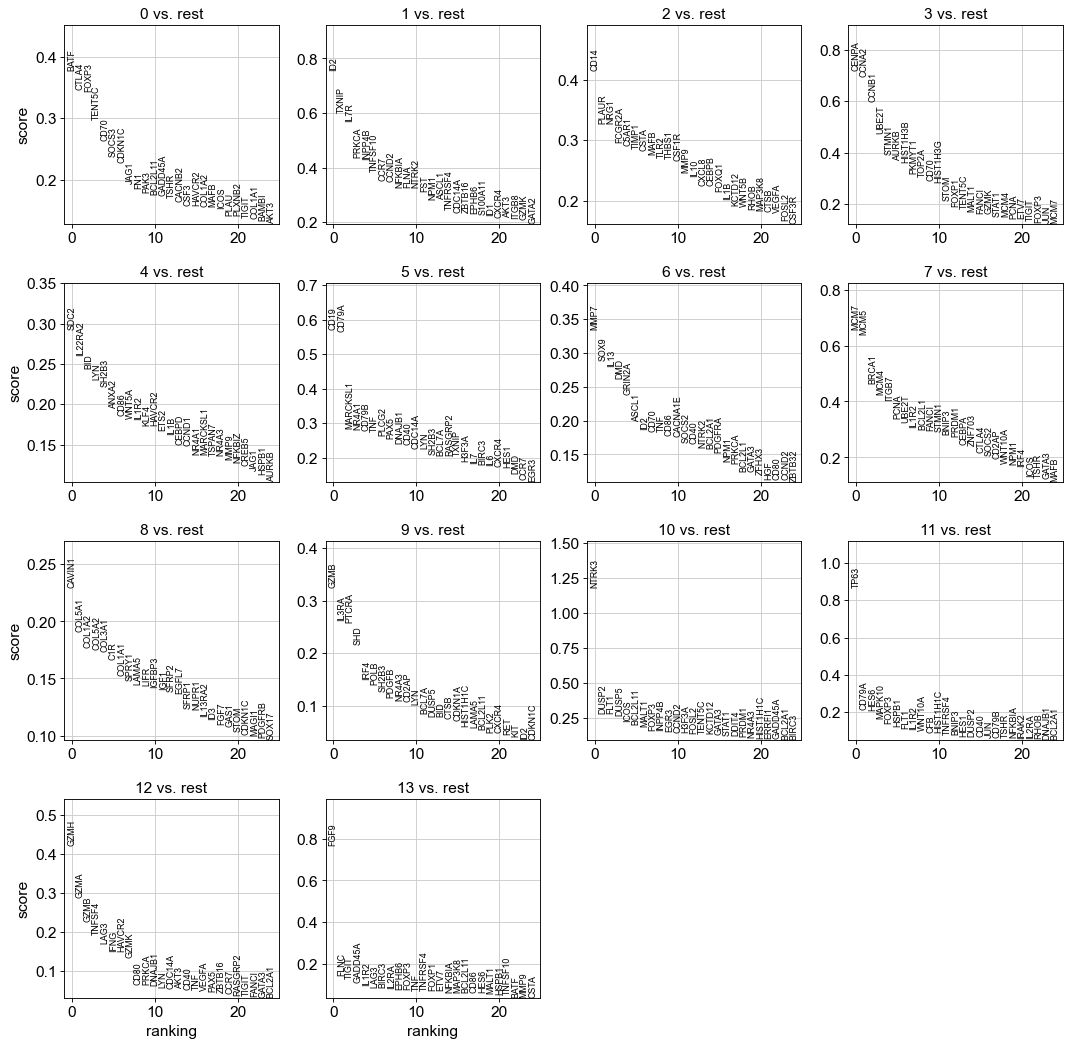

In [229]:
#Labelling clusters with marker genes
#Utilize 1024 HVGs and their respective names to choose the correct subplot cells based on this cluter method

sc.tl.rank_genes_groups(pcaHVG10, 'leiden', method='logreg')
sc.pl.rank_genes_groups(pcaHVG10, n_genes=25, sharey=False)



In [254]:
res = pcaHVG10.uns['rank_genes_groups']

groups = res['names'].dtype.names
name_attributes = ['names', 'scores']

df_markers = pd.DataFrame({g+'-'+key: res[key][g] for g in groups for key in name_attributes})

#dataframe looks at each cluster and the highest_variable_genes ranked based on its z_score (how similar the hvg to mean expression value of the cluster), higher score indicates this gene's standard deviation is the lowest with respect to the cluster
marker_names = [i for i in df_markers.iloc[0] if type(i) == str] #get first top row
print(marker_names)

['BATF', 'ID2', 'CD14', 'CENPA', 'SDC2', 'CD19', 'MMP7', 'MCM7', 'CAVIN1', 'GZMB', 'NTRK3', 'TP63', 'GZMH', 'FGF9']


Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.


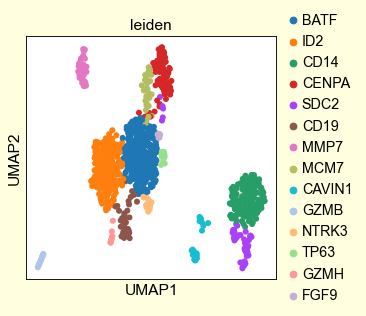

running PAGA
    finished (0:00:00)


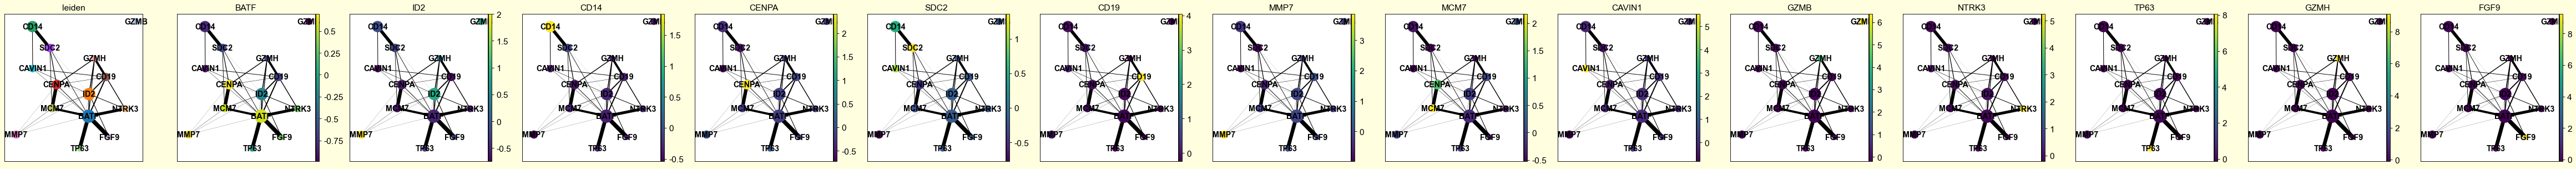

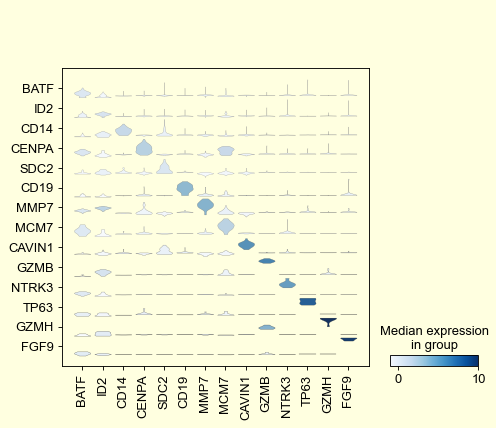

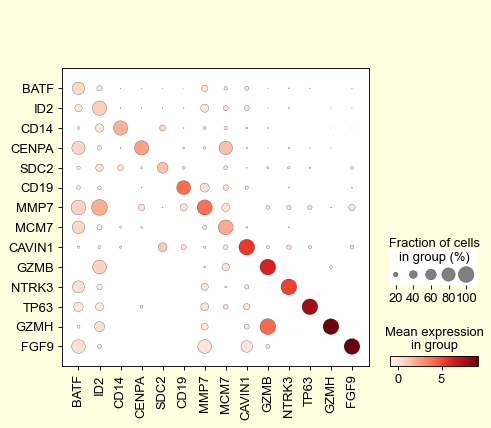

In [261]:
pcaHVG10.rename_categories('leiden', marker_names)
sc.pl.umap(pcaHVG10, color='leiden')

sc.tl.paga(pcaHVG10, groups='leiden')
sc.pl.paga(pcaHVG10, color=['leiden'] + marker_names)

sc.pl.stacked_violin(pcaHVG10, marker_names, groupby='leiden')
sc.pl.dotplot(pcaHVG10, marker_names, groupby='leiden')

In [252]:
#save dataset object
pcaHVG10.write(results_file, compression='gzip')